In [1]:
import sys
sys.path.append('../../data')
sys.path.append('../../model')
from load import *
from losses import *
from utils import *
from metrics import psnr, ssim
from model import DynamicUnet

from enum import Enum
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

from fastprogress.fastprogress import progress_bar

In [13]:
# Computer SPECS
gpu_id = 3
num_cores = 4
torch.cuda.set_device(gpu_id)

In [14]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
# model_path = data_pth/f'EM/models/feat_loss/'

# loading 3 rounds of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)
superres_metrics = [F.mse_loss, psnr, ssim]

In [15]:
arch = models.resnet34(True)
size = size_1
encoder_arch = nn.Sequential(*list(arch.children())[:-2])

nt = Enum('NormType', 'Batch BatchZero Weight Spectral')

model = DynamicUnet(encoder_arch, n_classes=1, 
                    img_size=(size,size), norm_type=nt.Weight)

In [16]:
loss_function = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
trn_loader = db.train_dl.dl

In [19]:
model.cuda()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [33]:
from fastai.callback import annealing_exp, Scheduler

In [34]:
sched = Scheduler((1e-8, 10), 100, annealing_exp)

In [63]:
def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(trn_loader)-1
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    sched = Scheduler((init_value, final_value), 100, annealing_exp)
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in progress_bar(trn_loader):
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs,labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        if batch_num >=100:
            break
        lr = sched.step()
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Using a target size (torch.Size([64, 3, 128, 128])) that is different to the input size (torch.Size([64, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


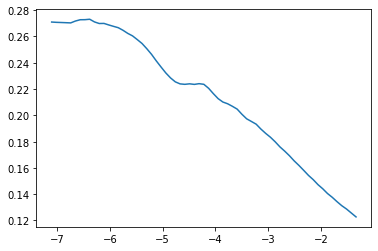

In [64]:
logs,losses = find_lr()
plt.plot(logs[10:-5],losses[10:-5])

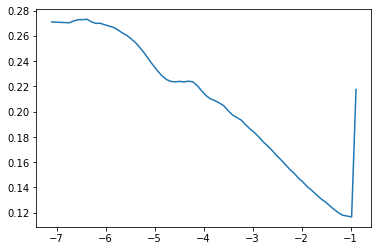

In [65]:
plt.plot(logs[10:],losses[10:])